In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix,make_scorer
from sklearn.utils import resample
from sklearn import datasets
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
import category_encoders as ce
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier
from pandas_profiling import ProfileReport

from catboost import Pool,CatBoostClassifier

%matplotlib inline

warnings.filterwarnings('ignore')

#### <span style="color:blue;font:Calibri">Importing our datasets. df_matches contains match data and df_balls contains ball-by-ball data.

In [2]:
df_matches = pd.read_csv('matches.csv',header=0)
df_matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [3]:
df_matches.columns

Index(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')

In [4]:
df_balls = pd.read_csv('deliveries.csv',header=0)
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [5]:
df_balls.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [6]:
df_balls.shape

(179078, 21)

In [7]:
df_balls.describe()

,match_id,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs
count,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000,179078.000000
mean,1802.252957,1.482952,10.162488,3.615587,0.000452,0.036721,0.004936,0.021136,0.004183,0.000056,1.246864,0.067032,1.313897
std,3472.322805,0.502074,5.677684,1.806966,0.021263,0.251161,0.116480,0.194908,0.070492,0.016709,1.608270,0.342553,1.605422
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,190.000000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,379.000000,1.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,567.000000,2.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,11415.000000,5.000000,20.000000,9.000000,1.000000,5.000000,4.000000,5.000000,5.000000,5.000000,7.000000,7.000000,10.000000


#### <span style="color:blue">Fixing the datasets</span>

Our data has some discrepancies, like names of stadiums written in 2 different ways. We will be fixing this, this can be checked by doing value_counts on suspected columns.

In [8]:
df_matches['venue'][df_matches.venue == 'M. Chinnaswamy Stadium'] = 'M Chinnaswamy Stadium'
df_matches['city'][df_matches.city.isin(['Bangalore','Bengaluru'])] = 'Bangalore/Bengaluru'
df_matches['venue'][df_matches.venue == 'M. A. Chidambaram Stadium'] = 'MA Chidambaram Stadium, Chepauk'

filling null values with 'NA' in df_balls

In [9]:
df_balls['dismissal_kind'][df_balls['dismissal_kind'].isna()] = 'NA'
df_balls['player_dismissed'][df_balls['player_dismissed'].isna()] = 'NA'
df_balls['fielder'][df_balls['fielder'].isna()] = 'NA'
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NA,NA,NA
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NA,NA,NA
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NA,NA,NA
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NA,NA,NA
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NA,NA,NA


## <span style="color:purple;font:Calibri">1. Creating new datasets from our provided ones</span>

We will be creating new datasets using df_matches and df_balls which will aggregate player_data and match data for analysis.

#### <span style="color:purple;font:Calibri">1. a. Player with most Man of the matches</span>

In [10]:
mom_data = df_matches.groupby('player_of_match',as_index=False)['id'].count().sort_values('id',ascending=False)
mom_data.head(10)

,player_of_match,id
35,CH Gayle,21
10,AB de Villiers,20
137,MS Dhoni,17
42,DA Warner,17
167,RG Sharma,17
222,YK Pathan,16
201,SR Watson,15
191,SK Raina,14
56,G Gambhir,13
123,MEK Hussey,12


#### <span style="color:purple;font:Calibri">1. b. Dataframe containing batsman data</span>

In [11]:
player_runs = df_balls.groupby('batsman',as_index=False)['batsman_runs'].sum()
player_runs.sort_values(by=['batsman_runs'],ascending=False,inplace=True)
player_matches = df_balls.groupby('batsman',as_index=False).agg({'match_id': pd.Series.nunique})
player_matches.sort_values(by=['match_id'],ascending=False,inplace=True)
player_matches.head()

,batsman,match_id
428,SK Raina,189
367,RG Sharma,182
384,RV Uthappa,170
290,MS Dhoni,170
486,V Kohli,169


In [12]:
player_data = player_runs.merge(player_matches,on=['batsman'])
player_data.rename(columns={'match_id':'matches'},inplace=True)
#mom_data.rename(columns={'player_of_match':'batsman','id':'MOM Wins'},inplace=True)
player_data = player_data.merge(mom_data.rename(columns={'player_of_match':'batsman','id':'MOM Wins'}),on=['batsman'])
player_data['average'] = player_data.batsman_runs/player_data.matches
player_data.sort_values(by=['batsman_runs'],inplace=True,ascending=False)
player_data.head(10)

,batsman,batsman_runs,matches,MOM Wins,average
0,V Kohli,5434,169,12,32.153846
1,SK Raina,5415,189,14,28.650794
2,RG Sharma,4914,182,17,27.000000
3,DA Warner,4741,126,17,37.626984
4,S Dhawan,4632,158,6,29.316456
5,CH Gayle,4560,124,21,36.774194
6,MS Dhoni,4477,170,17,26.335294
7,RV Uthappa,4446,170,7,26.152941
8,AB de Villiers,4428,142,20,31.183099
9,G Gambhir,4223,151,13,27.966887


In [13]:
batsman_balls = df_balls[df_balls.wide_runs == 0].groupby('batsman',as_index=False)['ball'].count()
batsman_balls.rename(columns={'ball':'balls_faced'},inplace=True)
player_data = player_data.merge(batsman_balls,on=['batsman'])
player_data['strk_rate'] = 100*(player_data['batsman_runs']/player_data['balls_faced'])
player_data.head()

,batsman,batsman_runs,matches,MOM Wins,average,balls_faced,strk_rate
0,V Kohli,5434,169,12,32.153846,4114,132.085561
1,SK Raina,5415,189,14,28.650794,3917,138.243554
2,RG Sharma,4914,182,17,27.000000,3744,131.250000
3,DA Warner,4741,126,17,37.626984,3306,143.405929
4,S Dhawan,4632,158,6,29.316456,3671,126.178153


In [14]:
player_data.head()

,batsman,batsman_runs,matches,MOM Wins,average,balls_faced,strk_rate
0,V Kohli,5434,169,12,32.153846,4114,132.085561
1,SK Raina,5415,189,14,28.650794,3917,138.243554
2,RG Sharma,4914,182,17,27.000000,3744,131.250000
3,DA Warner,4741,126,17,37.626984,3306,143.405929
4,S Dhawan,4632,158,6,29.316456,3671,126.178153


#### <span style="color:purple;font:Calibri">1. c. Dataframe containing bowler data</span>

In [15]:
player_wickets = df_balls[(df_balls.player_dismissed.notna()) & 
                          (~df_balls['dismissal_kind'].isin(
                              ['NA','run out', 'retired hurt', 'obstructing the field']))].groupby('bowler',as_index=False)['player_dismissed'].count()
player_matches = df_balls.groupby('bowler',as_index=False).agg({'match_id': pd.Series.nunique})
player_wickets = player_wickets.merge(player_matches.rename(columns={'match_id':'matches'}),on='bowler')
df_balls['bowler_runs_conceded'] = df_balls.wide_runs + df_balls.noball_runs + df_balls.penalty_runs + df_balls.batsman_runs
player_runs = df_balls.groupby('bowler',as_index=False)['bowler_runs_conceded'].sum()
bowler_data = player_wickets.merge(player_runs[['bowler','bowler_runs_conceded']],on='bowler')
bowler_data['average'] = bowler_data.bowler_runs_conceded/bowler_data.player_dismissed
bowler_data = bowler_data.merge(mom_data.rename(columns={'player_of_match':'bowler','id':'MOM Wins'}),on=['bowler'])
bowler_data.rename(columns={'player_dismissed':'wickets_taken'},inplace=True)
top_10_bowlers = bowler_data.sort_values(by='wickets_taken',ascending=False).head(10)
top_10_bowlers

,bowler,wickets_taken,matches,bowler_runs_conceded,average,MOM Wins
137,SL Malinga,170,122,3395,19.970588,6
3,A Mishra,156,147,3804,24.384615,11
50,Harbhajan Singh,150,157,3979,26.526667,8
111,PP Chawla,149,156,4086,27.422819,3
35,DJ Bravo,147,131,3662,24.911565,3
20,B Kumar,133,117,3185,23.947368,5
114,R Ashwin,125,136,3337,26.696000,2
139,SP Narine,122,109,2884,23.639344,9
150,UT Yadav,119,118,3550,29.831933,8
119,RA Jadeja,108,142,3176,29.407407,8


In [16]:
bowler_balls = df_balls[(df_balls.wide_runs == 0) & (df_balls.noball_runs == 0)].groupby('bowler',as_index=False)['ball'].count()
bowler_balls.rename(columns={'ball':'balls_bowled'},inplace=True)
bowler_data = bowler_data.merge(bowler_balls,on=['bowler'])
bowler_data['bowler_strk_rate'] = (bowler_data['balls_bowled']/bowler_data['wickets_taken'])
bowler_data.head()

,bowler,wickets_taken,matches,bowler_runs_conceded,average,MOM Wins,balls_bowled,bowler_strk_rate
0,A Chandila,11,12,242,22.000000,1,234,21.272727
1,A Joseph,6,3,92,15.333333,1,52,8.666667
2,A Kumble,45,42,1058,23.511111,3,965,21.444444
3,A Mishra,156,147,3804,24.384615,11,3102,19.884615
4,A Nehra,106,88,2495,23.537736,6,1908,18.000000


#### <span style="color:purple;font:Calibri">1. d. Fetching all player names and team names for categorical features encoding</span>

In [17]:
allplayers = list(df_balls['batsman'].unique()) + list(df_balls['bowler'].unique()) + list(df_balls['non_striker'].unique())
allplayers_unique = set(allplayers)

allteams = list(df_balls['batting_team'].unique()) + list(df_balls['bowling_team'].unique())
allteams_unique = set(allteams)


### <span style="color:orange;font:Calibri">Some analysis on above created datasets</span>

##### <span style="color:orange;font:Calibri">Team winning batting 1st or 2nd? in each ground</span>

In [18]:
field_win = df_matches[df_matches['win_by_runs'] == 0].groupby(['city','venue'],as_index=False)['id'].count()
field_win.rename(columns={'id':'Fielding First Win Count'},inplace=True)
bat_win = df_matches[df_matches['win_by_runs'] > 0].groupby(['city','venue'],as_index=False)['id'].count()
bat_win.rename(columns={'id':'Batting First Win Count'},inplace=True)
ground_win = field_win.set_index(['city','venue']).join(bat_win.set_index(['city','venue']))
ground_win['Diff'] = ground_win['Batting First Win Count'] - ground_win['Fielding First Win Count']
ground_win.sort_values(by='Diff',ascending=False).fillna(0).head()

,,Fielding First Win Count,Batting First Win Count,Diff
city,venue,,,
Chennai,"MA Chidambaram Stadium, Chepauk",23,34.0,11.0
Pune,Subrata Roy Sahara Stadium,6,11.0,5.0
Durban,Kingsmead,6,9.0,3.0
Visakhapatnam,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium,4,7.0,3.0
Hyderabad,Rajiv Gandhi Intl. Cricket Stadium,3,5.0,2.0


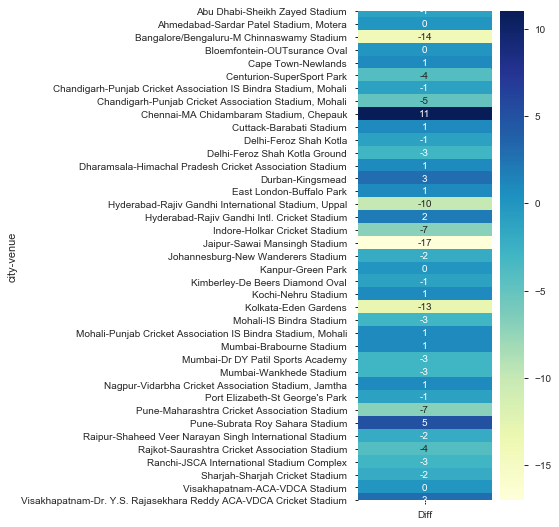

In [19]:
plotter=ground_win.reset_index()
plotter = plotter[['city','venue','Diff']].fillna(0)
plotter.set_index(['city','venue'],inplace=True)
plt.figure(figsize=(3,9))
sns.heatmap(plotter,annot=True,cmap="YlGnBu")
plt.show()

We can see teams batting first win in Chennai and Pune but teams batting second win in Kolkata, Jaipur, and Bangalore

##### <span style="color:orange;font:Calibri">Team favouring ground</span>

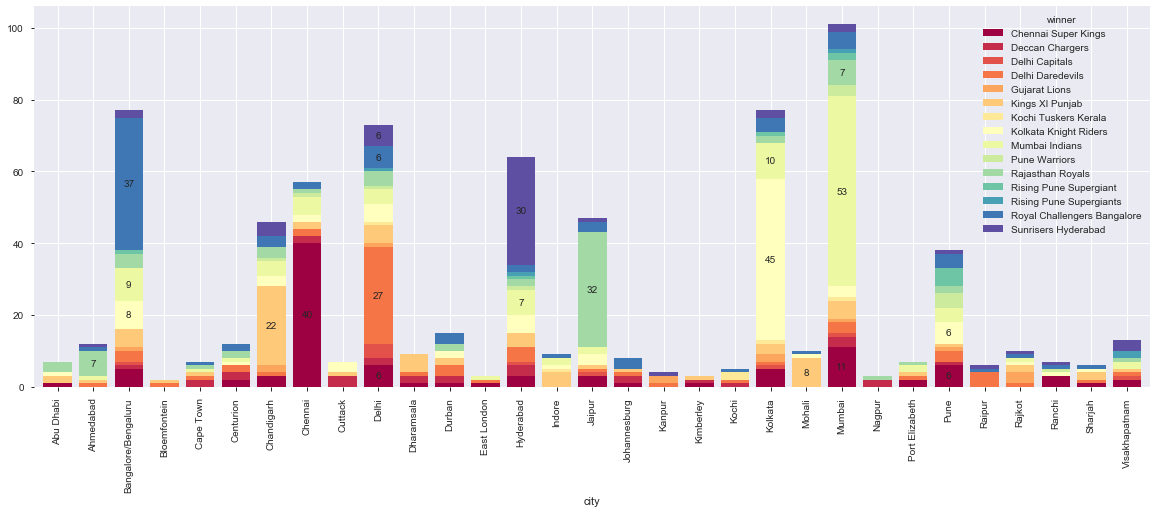

In [20]:
ground_winner = df_matches.groupby(['city','winner'])['id'].count().unstack('winner').fillna(0)
cmap = cm.get_cmap('Spectral')
ax = ground_winner.plot(kind='bar',stacked=True,figsize=(20,7),width=0.8,colormap=cmap)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height>5:
        ax.text(x+width/2, 
            y+height/2, 
            int(height), 
            horizontalalignment='center', 
            verticalalignment='center')

All the teams are favoring thier homegrounds, There is a near equal fight in Pune. 

##### <span style="color:orange;font:Calibri">Top 10 batsman and bowlers</span>

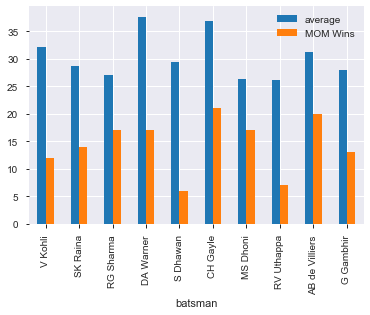

In [21]:
top_10_batsman = player_data.head(10).set_index('batsman')
ax = top_10_batsman[['average','MOM Wins']].plot.bar()

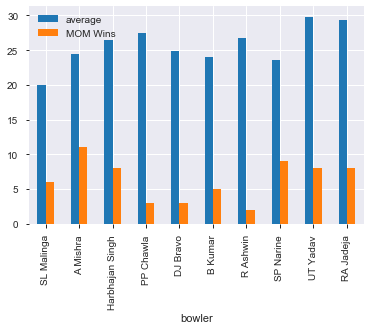

In [22]:
ax = top_10_bowlers.set_index('bowler')[['average','MOM Wins']].plot.bar()

### <span style="color:brown;font:Calibri">2. Creating enhanced df_balls dataframe which also contains <b>match situation</b> data for each ball</span>

##### <span style="color:brown;font:Calibri">We need to add some columns like - Bowler data, Batsman data, Wickets Fallen, Score, Last Wicket Fallen Over, Average Total at venue </span>

This task will be done using utility file which contains functions for readng match data and create situational columns. As this requires reading dataframe's previous rows we need to save and re-use this file.

In [23]:
# from ipl_utils import createBallsExtended
# df_balls = createBallsExtended(df_balls)

# # Saving the hard work
# export_balls = df_balls.to_csv('df_balls.csv', index = None, header=True)

The above step has been already executed and new file has been provided, importing the file in below step

In [24]:
df_balls = pd.read_csv('df_balls.csv',header=0)
df_balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,dismissal_kind,fielder,bowler_runs_conceded,wickets_fallen,score,last_wicket_ball,striker_runs,non_striker_runs,bowler_match_runs,bowler_match_wickets
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,0,0,0,0.0,0,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,0,0,0,0.0,0,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,4,0,4,0.0,4,0,4,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,0,0,4,0.0,4,0,4,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,NaN,NaN,2,0,6,0.0,4,0,6,0


In [25]:
profile = ProfileReport(df_balls, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

In [25]:
df_balls['dismissal_kind'][df_balls['dismissal_kind'].isna()] = 'NA'
df_balls['player_dismissed'][df_balls['player_dismissed'].isna()] = 'NA'
df_balls['fielder'][df_balls['fielder'].isna()] = 'NA'

## Predictions

### <span style="color:green;font:Calibri">3. Prediction of next ball. Dataframe df_balls_matches preparation start </span>

In [26]:
df_balls_matches = df_balls.merge(df_matches,left_on='match_id',right_on='id')
df_balls_matches.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder', 'bowler_runs_conceded', 'wickets_fallen',
       'score', 'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'date', 'team1', 'team2', 'toss_winner', 'toss_decision', 'result',
       'dl_applied', 'winner', 'win_by_runs', 'win_by_wickets',
       'player_of_match', 'venue', 'umpire1', 'umpire2', 'umpire3'],
      dtype='object')

In [27]:
df_balls_matches = df_balls_matches.drop(['umpire1', 'umpire2', 'umpire3','date','dismissal_kind', 'fielder', 
                                          'bowler_runs_conceded','winner', 'win_by_runs', 'win_by_wickets',
       'player_of_match'],axis=1)
df_balls_matches.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'wickets_fallen', 'score', 'last_wicket_ball', 'striker_runs',
       'non_striker_runs', 'bowler_match_runs', 'bowler_match_wickets', 'id',
       'season', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'result', 'dl_applied', 'venue'],
      dtype='object')

In [28]:
bowler_data.head()

,bowler,wickets_taken,matches,bowler_runs_conceded,average,MOM Wins,balls_bowled,bowler_strk_rate
0,A Chandila,11,12,242,22.000000,1,234,21.272727
1,A Joseph,6,3,92,15.333333,1,52,8.666667
2,A Kumble,45,42,1058,23.511111,3,965,21.444444
3,A Mishra,156,147,3804,24.384615,11,3102,19.884615
4,A Nehra,106,88,2495,23.537736,6,1908,18.000000


In [29]:
df_balls_matches = df_balls_matches.merge(bowler_data.rename(columns={'average':'bowling_average'}),on='bowler')
df_balls_matches.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,result,dl_applied,venue,wickets_taken,matches,bowler_runs_conceded,bowling_average,MOM Wins,balls_bowled,bowler_strk_rate
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,1,MC Henriques,S Dhawan,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,2,MC Henriques,S Dhawan,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,3,S Dhawan,MC Henriques,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,4,S Dhawan,MC Henriques,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,5,MC Henriques,S Dhawan,YS Chahal,0,...,normal,0,"Rajiv Gandhi International Stadium, Uppal",100,83,2366,23.66,1,1788,17.88


In [30]:
player_data.head()

,batsman,batsman_runs,matches,MOM Wins,average,balls_faced,strk_rate
0,V Kohli,5434,169,12,32.153846,4114,132.085561
1,SK Raina,5415,189,14,28.650794,3917,138.243554
2,RG Sharma,4914,182,17,27.000000,3744,131.250000
3,DA Warner,4741,126,17,37.626984,3306,143.405929
4,S Dhawan,4632,158,6,29.316456,3671,126.178153


In [31]:
df_balls_matches = df_balls_matches.merge(player_data.rename(columns={'average':'batting_average'}),on='batsman')
df_balls_matches.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs_x', 'extra_runs', 'total_runs', 'player_dismissed',
       'wickets_fallen', 'score', 'last_wicket_ball', 'striker_runs',
       'non_striker_runs', 'bowler_match_runs', 'bowler_match_wickets', 'id',
       'season', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'result', 'dl_applied', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'batsman_runs_y', 'matches_y', 'MOM Wins_y',
       'batting_average', 'balls_faced', 'strk_rate'],
      dtype='object')

In [32]:
df_balls_matches['total_runs'].unique()

array([ 0,  1,  2,  6,  4,  5,  3, 10,  8,  7], dtype=int64)

In [33]:
df_balls_matches.shape

(123040, 49)

<span style="color:green">Adding column result to join runs and wickets for that ball - O for out, NO for not out + total runs on that ball. This can become target variable for each ball prediction.</span>

In [34]:
df_balls_matches['result'] = np.where(df_balls_matches['player_dismissed'] != 'NA', 'O', 'NO')

In [35]:
df_balls_matches['result'] += df_balls_matches['total_runs'].astype(str)

In [36]:
df_balls_matches['result'].value_counts()

NO1     50181
NO0     37659
NO4     14099
NO2      8903
O0       5713
NO6      5522
NO3       450
NO5       224
O1        201
NO8        46
NO7        24
NO10        9
O2          7
O6          1
O4          1
Name: result, dtype: int64

#### <span style="color:green;font:Calibri">3. a. Removing outliers</span>

In [37]:
df_balls_matches = df_balls_matches[~df_balls_matches['result'].isin(['NO7','NO8','NO10','O6','O4','O2'])]

#### <span style="color:green;font:Calibri">3. b. Adding columns 'venue_average'</span>

In [38]:
venue_totals_inone = df_balls_matches[df_balls_matches['inning'] == 1].groupby('venue',as_index=False)['total_runs'].sum()
venue_totals_intwo = df_balls_matches[df_balls_matches['inning'] == 2].groupby('venue',as_index=False)['total_runs'].sum()
venue_matches = df_balls_matches.groupby('venue',as_index=False).agg({'match_id': pd.Series.nunique})
venue_totals = venue_totals_inone.merge(venue_matches,on='venue')
venue_totals.rename(columns={'match_id':'venue_matches','total_runs':'venue_runs_inone'},inplace=True)
venue_totals = venue_totals.merge(venue_totals_intwo,on='venue')
venue_totals.rename(columns={'total_runs':'venue_runs_intwo'},inplace=True)
venue_totals.head(10)

,venue,venue_runs_inone,venue_matches,venue_runs_intwo
0,ACA-VDCA Stadium,171,2,234
1,Barabati Stadium,961,7,823
2,Brabourne Stadium,1455,11,1297
3,Buffalo Park,346,3,219
4,De Beers Diamond Oval,358,3,360
5,Dr DY Patil Sports Academy,1459,17,1606
6,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,1304,11,1001
7,Dubai International Cricket Stadium,888,7,864
8,Eden Gardens,8657,77,8273
9,Feroz Shah Kotla,7329,67,6610


In [39]:
venue_totals['inning_one_average_total'] = venue_totals['venue_runs_inone']/venue_totals['venue_matches']
venue_totals['inning_two_average_total'] = venue_totals['venue_runs_intwo']/venue_totals['venue_matches']
venue_totals.sort_values(by='inning_one_average_total',ascending=False)
venue_totals.head()

,venue,venue_runs_inone,venue_matches,venue_runs_intwo,inning_one_average_total,inning_two_average_total
0,ACA-VDCA Stadium,171,2,234,85.500000,117.000000
1,Barabati Stadium,961,7,823,137.285714,117.571429
2,Brabourne Stadium,1455,11,1297,132.272727,117.909091
3,Buffalo Park,346,3,219,115.333333,73.000000
4,De Beers Diamond Oval,358,3,360,119.333333,120.000000


In [40]:
df_balls_matches = df_balls_matches.merge(venue_totals,on='venue')

In [41]:
df_balls_matches = df_balls_matches.drop(['batting_team', 'bowling_team','wide_runs', 'bye_runs', 'legbye_runs',
       'noball_runs', 'penalty_runs', 'batsman_runs_x','batsman_runs_y', 'extra_runs','player_dismissed',
       'total_runs'],axis=1)
df_balls_matches.columns

Index(['match_id', 'inning', 'over', 'ball', 'batsman', 'non_striker',
       'bowler', 'is_super_over', 'wickets_fallen', 'score',
       'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'result',
       'dl_applied', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'matches_y', 'MOM Wins_y', 'batting_average',
       'balls_faced', 'strk_rate', 'venue_runs_inone', 'venue_matches',
       'venue_runs_intwo', 'inning_one_average_total',
       'inning_two_average_total'],
      dtype='object')

In [42]:
df_balls_matches['city'] = np.where(df_balls_matches['city'].isna(), 'nocity',df_balls_matches['city'])
df_balls_matches['city'].unique()

array(['Hyderabad', 'Bangalore/Bengaluru', 'Jaipur', 'Ahmedabad',
       'Mumbai', 'Durban', 'Pune', 'Visakhapatnam', 'Ranchi', 'Kolkata',
       'Delhi', 'Kanpur', 'Chandigarh', 'Mohali', 'Raipur',
       'Johannesburg', 'Cuttack', 'Cape Town', 'Chennai', 'Abu Dhabi',
       'Dharamsala', 'Rajkot', 'Sharjah', 'nocity', 'Port Elizabeth',
       'Kochi', 'Bloemfontein', 'Indore', 'Centurion', 'Kimberley',
       'East London', 'Nagpur'], dtype=object)

In [43]:
df_balls_matches.columns

Index(['match_id', 'inning', 'over', 'ball', 'batsman', 'non_striker',
       'bowler', 'is_super_over', 'wickets_fallen', 'score',
       'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'result',
       'dl_applied', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'matches_y', 'MOM Wins_y', 'batting_average',
       'balls_faced', 'strk_rate', 'venue_runs_inone', 'venue_matches',
       'venue_runs_intwo', 'inning_one_average_total',
       'inning_two_average_total'],
      dtype='object')

### Label encoding category feaatures

In [44]:
df_balls_matches_pred = df_balls_matches.copy()
df_balls_matches_pred.head()

,match_id,inning,over,ball,batsman,non_striker,bowler,is_super_over,wickets_fallen,score,...,matches_y,MOM Wins_y,batting_average,balls_faced,strk_rate,venue_runs_inone,venue_matches,venue_runs_intwo,inning_one_average_total,inning_two_average_total
0,1,1,4,1,MC Henriques,S Dhawan,YS Chahal,0,1,29,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
1,1,1,4,2,MC Henriques,S Dhawan,YS Chahal,0,1,30,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
2,1,1,4,5,MC Henriques,S Dhawan,YS Chahal,0,1,32,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
3,1,1,7,2,MC Henriques,S Dhawan,YS Chahal,0,1,60,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
4,1,1,7,3,MC Henriques,S Dhawan,YS Chahal,0,1,61,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429


In [45]:
#issue in 'city' data
label_encoder = preprocessing.LabelEncoder()
team_label_encoder = preprocessing.LabelEncoder()
player_label_encoder = preprocessing.LabelEncoder()
cols = ['venue','city', 'toss_decision']
for c in cols:
    df_balls_matches_pred[c] = label_encoder.fit_transform(df_balls_matches_pred[c])

team_cols = ['team1', 'team2', 'toss_winner']
team_label_encoder.fit(pd.DataFrame(allteams_unique))
for t in team_cols:
    df_balls_matches_pred[t] = team_label_encoder.transform(df_balls_matches_pred[t])

player_cols = ['batsman', 'non_striker', 'bowler']
player_label_encoder.fit(pd.DataFrame(allplayers_unique))
for p in player_cols:
    df_balls_matches_pred[p] = player_label_encoder.transform(df_balls_matches_pred[p])

df_balls_matches_pred.head()

,match_id,inning,over,ball,batsman,non_striker,bowler,is_super_over,wickets_fallen,score,...,matches_y,MOM Wins_y,batting_average,balls_faced,strk_rate,venue_runs_inone,venue_matches,venue_runs_intwo,inning_one_average_total,inning_two_average_total
0,1,1,4,1,290,423,553,0,1,29,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
1,1,1,4,2,290,423,553,0,1,30,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
2,1,1,4,5,290,423,553,0,1,32,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
3,1,1,7,2,290,423,553,0,1,60,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429
4,1,1,7,3,290,423,553,0,1,61,...,50,2,19.38,756,128.174603,5405,56,5296,96.517857,94.571429


In [46]:
df_balls_matches_pred.sort_values(by=['match_id','inning','over','ball'])['toss_decision'].head(10)

0      1
1      1
221    1
222    1
2      1
223    1
237    1
16     1
238    1
17     1
Name: toss_decision, dtype: int32

In [47]:
y = df_balls_matches_pred.pop('result').values
X = df_balls_matches_pred.values

### PCA and scaling

In [48]:
# Scale input features to N(0,1)
X_scal = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit(X_scal).transform(X)

In [49]:
X_r

array([[ -134.0688109 , -3300.28617221,  4440.40526306, -3216.97099874,
         -319.00066348,   144.47050622],
       [ -133.46357129, -3300.27510627,  4440.75151159, -3216.59458198,
         -318.48756431,   144.62922314],
       [ -132.20469719, -3300.23679075,  4441.43321068, -3215.89491412,
         -317.51229755,   144.96192041],
       ...,
       [   87.14161274,  -797.1524448 ,   882.35750794,   488.90222679,
         -586.98749918,   309.457589  ],
       [  124.14785943, -1121.17085201,   803.53432826,   482.7249379 ,
         -575.69920021,   349.75375631],
       [  124.75309903, -1121.15978607,   803.88057679,   483.10135466,
         -575.18610104,   349.91247324]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)

In [51]:
print('Accuracy : ',accuracy_score(y_test,y_pred),'F1 score:',f1_score(y_test,y_pred,average='macro'))

Accuracy :  0.38713350412752634 F1 score: 0.07560539088575201


#### Lets select some features

Text(0, 0.5, 'Feature Importance')

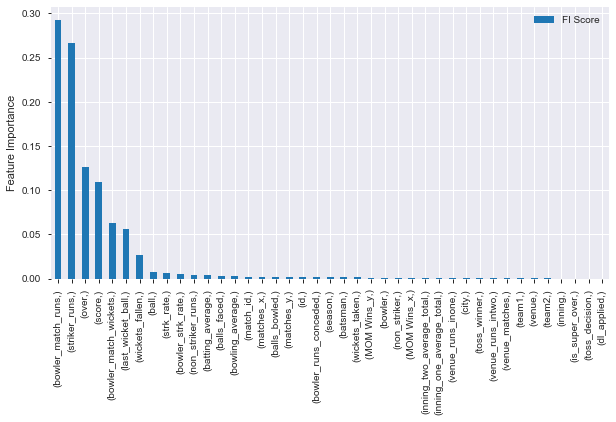

In [52]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF = RF.fit(X,y)
FI_df = pd.DataFrame(RF.feature_importances_, index=[df_balls_matches_pred.columns],columns =['FI Score'])
FI_df.sort_values('FI Score', inplace=True, ascending = False)
%matplotlib inline
pl = FI_df.plot.bar(figsize=(10,5))
pl.set_ylabel("Feature Importance")

Text(0, 0.5, 'Feature Importance')

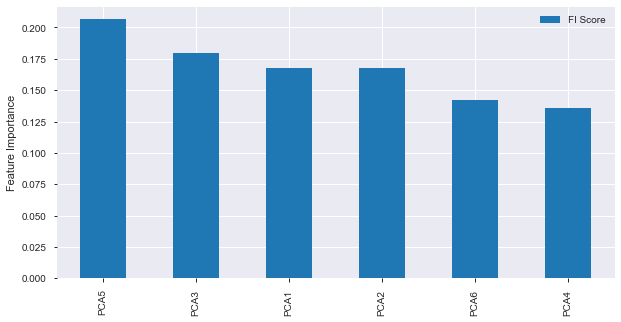

In [53]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF = RF.fit(X_r,y)
FI_df = pd.DataFrame(RF.feature_importances_, index=['PCA1','PCA2'],columns =['FI Score'])
FI_df.sort_values('FI Score', inplace=True, ascending = False)

pl = FI_df.plot.bar(figsize=(10,5))
pl.set_ylabel("Feature Importance")

In [54]:
gnb = GaussianNB()
dtree = DecisionTreeClassifier()
kNN = KNeighborsClassifier(n_neighbors=3)
folds = 10
models =  [gnb,dtree,kNN]
for m in models:
    cv_results = cross_validate(m, X_r, y, cv= folds,scoring='accuracy', return_train_score=False, verbose = 0, n_jobs = -1)
    print("{} x CV {:22} Accuracy: {:.2f} ".format(folds, type(m).__name__, cv_results['test_score'].mean()))


10 x CV GaussianNB             Accuracy: 0.38 
10 x CV DecisionTreeClassifier Accuracy: 0.24 
10 x CV KNeighborsClassifier   Accuracy: 0.30 


In [55]:
gnb_bag = BaggingClassifier(gnb, 
                            n_estimators = 10,
                            max_samples = 1.0, 
                            bootstrap = True)

tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 10,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In [56]:
folds = 5
v = 0
scores_gnb = cross_val_score(gnb, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_gnb_bag = cross_val_score(gnb_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for GNB {:.2f}".format(scores_gnb.mean()))
print("Mean for GNB_bag {:.2f}".format(scores_gnb_bag.mean()))

scores_tree = cross_val_score(dtree, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_tree_bag = cross_val_score(tree_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for D-Tree {:.2f}".format(scores_tree.mean()))
print("Mean for D_Tree_bag {:.2f}".format(scores_tree_bag.mean()))

Mean for GNB 0.38
Mean for GNB_bag 0.38
Mean for D-Tree 0.25
Mean for D_Tree_bag 0.33


In [57]:
df_balls_matches_cat = df_balls_matches.copy()
df_balls_matches_cat = df_balls_matches_cat.drop(['dl_applied','toss_winner','toss_decision'], axis=1)
#df_balls_matches_cat.select_dtypes(include=['object']).columns
df_balls_matches_cat.columns

Index(['match_id', 'inning', 'over', 'ball', 'batsman', 'non_striker',
       'bowler', 'is_super_over', 'wickets_fallen', 'score',
       'last_wicket_ball', 'striker_runs', 'non_striker_runs',
       'bowler_match_runs', 'bowler_match_wickets', 'id', 'season', 'city',
       'team1', 'team2', 'result', 'venue', 'wickets_taken', 'matches_x',
       'bowler_runs_conceded', 'bowling_average', 'MOM Wins_x', 'balls_bowled',
       'bowler_strk_rate', 'matches_y', 'MOM Wins_y', 'batting_average',
       'balls_faced', 'strk_rate', 'venue_runs_inone', 'venue_matches',
       'venue_runs_intwo', 'inning_one_average_total',
       'inning_two_average_total'],
      dtype='object')

In [70]:
df_balls_matches_cat['result'].value_counts()

NO1    50181
NO0    37659
NO4    14099
NO2     8903
O0      5713
NO6     5522
NO3      450
NO5      224
O1       201
Name: result, dtype: int64

In [58]:
# Trying CatBoostClassifier


cat_features = [4,5,6,17,18,19,20]

y = df_balls_matches_cat['result'].values
X = df_balls_matches_cat.loc[:, df_balls_matches_cat.columns != 'result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_label = y_train
eval_label = y_test


train_dataset = Pool(data=X_train,
                     label=train_label,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_test,
                    label=eval_label,
                    cat_features=cat_features)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=20,
                           learning_rate=0.50,
                           depth=8,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(eval_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_dataset, 
                          prediction_type='RawFormulaVal')

0:	learn: 1.5047684	total: 3.62s	remaining: 1m 8s
1:	learn: 1.3930948	total: 6.56s	remaining: 59.1s
2:	learn: 1.3373538	total: 8.92s	remaining: 50.5s
3:	learn: 1.2852386	total: 11.1s	remaining: 44.3s
4:	learn: 1.2708606	total: 12.8s	remaining: 38.5s
5:	learn: 1.2505333	total: 15s	remaining: 35s
6:	learn: 1.2442622	total: 17.5s	remaining: 32.4s
7:	learn: 1.2329377	total: 19.7s	remaining: 29.6s
8:	learn: 1.2285248	total: 22s	remaining: 26.8s
9:	learn: 1.2213576	total: 24.3s	remaining: 24.3s
10:	learn: 1.2181618	total: 26.5s	remaining: 21.7s
11:	learn: 1.2097681	total: 28.7s	remaining: 19.2s
12:	learn: 1.2073080	total: 31s	remaining: 16.7s
13:	learn: 1.2019460	total: 33.4s	remaining: 14.3s
14:	learn: 1.1996832	total: 35.9s	remaining: 12s
15:	learn: 1.1983429	total: 38.2s	remaining: 9.55s
16:	learn: 1.1960297	total: 40.6s	remaining: 7.16s
17:	learn: 1.1915610	total: 43.3s	remaining: 4.81s
18:	learn: 1.1838212	total: 46.2s	remaining: 2.43s
19:	learn: 1.1791094	total: 48.9s	remaining: 0us


In [59]:
print('Accuracy : ',accuracy_score(y_test,preds_class),'F1 score:',f1_score(y_test,preds_class,average='macro'))

Accuracy :  0.5242161766499939 F1 score: 0.22009496176145676


In [61]:
display_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display_comparison.head(5)

,Actual,Predicted
0,NO2,NO1
1,NO0,NO1
2,NO0,NO1
3,NO0,NO1
4,O0,NO1


In [69]:
np.unique(y_pred)

array(['NO1', 'NO2'], dtype='<U3')

In [65]:
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted    NO1   NO2    All
True                         
NO0         6953   579   7532
NO1         9314   753  10067
NO2         1526   206   1732
NO3           86    10     96
NO4         2604   238   2842
NO5           41     0     41
NO6          970   116   1086
O0          1036   127   1163
O1            32     0     32
All        22562  2029  24591


# Predicting each over results

In [ ]:
df_balls['is_wicket'] = np.where(df_balls['player_dismissed'] == 'NA', 0, 1)

In [ ]:
df_balls.is_wicket.value_counts()

In [ ]:
df_balls.head()

In [ ]:
df_over = df_balls.groupby(['match_id','over','inning'],as_index=False).agg({'batsman' : lambda x: x.head(1),
                                                              'non_striker' : lambda x: x.head(1),
                                                                   'batting_team' : lambda x: x.head(1),
                                                              'batting_team' : lambda x: x.head(1),
                                                            'bowling_team' : lambda x: x.head(1),
                                                            'bowler' : lambda x: x.head(1),
                                                                   'bowler_runs_conceded' : np.sum,
                                                                   'total_runs' : np.sum,
                                                                   'is_wicket' : np.sum,
                                                             'bowler_match_wickets': lambda x: x.head(1),
                                                             'striker_runs' : lambda x: x.head(1),
                                                             'bowler_match_runs' : lambda x: x.head(1) ,
                                                             'non_striker_runs': lambda x: x.head(1),
                                                             'score' : lambda x: x.head(1),
                                                             'last_wicket_ball' : lambda x: x.head(1)})
# over_bat = df_over['batsman'].str.split(',',expand=True).fillna('NA')
# over_bowl = df_over['bowler'].str.split(',',expand=True).fillna('NA')
# df_over['batsman1'] = over_bat[0]
# df_over['batsman2'] = over_bat[1]
# df_over['batsman3'] = over_bat[2]
# df_over['batsman4'] = over_bat[3]
# df_over['batsman5'] = over_bat[4]
# df_over['bowler1'] = over_bowl[0]
# df_over['bowler2'] = over_bowl[1]
# df_over = df_over.drop(['batsman','bowler'],axis=1)
df_over.head()

In [ ]:
profile = ProfileReport(df_over, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

In [ ]:
df_over_ext = df_over.copy()

In [ ]:
df_over_ext = df_over_ext.merge(player_data,on='batsman')
df_over_ext = df_over_ext.merge(bowler_data,on='bowler')
df_over_ext = df_over_ext.merge(player_data,left_on='non_striker',right_on='batsman',suffixes=('_str','_nstr'))
df_over_ext.head()

In [ ]:
df_over_ext = df_over_ext.drop(['batsman_nstr'],axis=1)
df_over_ext.columns

### Predict runs in each over

In [ ]:
# df_over['result'] = df_over['total_runs'] + (0.1)*df_over['is_wicket']
# df_over = df_over.drop(['total_runs','is_wicket'],axis=1)
# df_over.head()

## If a wicket is going to fall in the over

In [ ]:
df_over_wickets = df_over_ext.drop(['total_runs','bowler_runs_conceded_x','bowler_runs_conceded_y'],axis=1)

In [ ]:
profile = ProfileReport(df_over_wickets, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

In [ ]:
df_over_wickets.columns

In [ ]:
df_over_en = df_over_wickets.copy()

In [ ]:
label_encoder = preprocessing.LabelEncoder()
team_label_encoder = preprocessing.LabelEncoder()
player_label_encoder = preprocessing.LabelEncoder()

team_cols = ['batting_team', 'bowling_team']
team_label_encoder.fit(pd.DataFrame(allteams_unique))
for t in team_cols:
    df_over_en[t] = team_label_encoder.transform(df_over_en[t])

player_cols = ['batsman_str', 'non_striker', 'bowler']
player_label_encoder.fit(pd.DataFrame(allplayers_unique))
for p in player_cols:
    df_over_en[p] = player_label_encoder.transform(df_over_en[p])

df_over_en.head()

We set the label class as 'is_wicket' to 0 if no wicket falls, and 1 if any wicket falls. (Making this a binary classification task)

In [ ]:
df_over_en['is_wicket'] = np.where(df_over_en['is_wicket'] == 0, 0, 1)

In [ ]:
df_over_en['is_wicket'].value_counts()

In [ ]:
y = df_over_en['is_wicket'].values
X = df_over_en.loc[:, df_over_en.columns != 'is_wicket'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
print('Accuracy : ',accuracy_score(y_test,y_pred),'F1 score:',f1_score(y_test,y_pred,average='macro'))

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF = RF.fit(X,y)
FI_df = pd.DataFrame(RF.feature_importances_, index=df_over_en.columns,columns =['FI Score'])
FI_df.sort_values('FI Score', inplace=True, ascending = False)
%matplotlib inline
pl = FI_df.plot.bar(figsize=(10,5))
pl.set_ylabel("Feature Importance")

### PCA for over data

In [ ]:
# Scale input features to N(0,1)
X_scal = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit(X_scal).transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
print('Accuracy : ',accuracy_score(y_test,y_pred),'F1 score:',f1_score(y_pred,y_test,average='macro'))

Accuracy increased after PCA and normalisation

In [ ]:
dtree = DecisionTreeClassifier()
gnb_bag = BaggingClassifier(gnb, 
                            n_estimators = 10,
                            max_samples = 1.0, 
                            bootstrap = True)

tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 10,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In [ ]:
folds = 5
v = 0
scores_gnb = cross_val_score(gnb, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_gnb_bag = cross_val_score(gnb_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for GNB {:.2f}".format(scores_gnb.mean()))
print("Mean for GNB_bag {:.2f}".format(scores_gnb_bag.mean()))

scores_tree = cross_val_score(dtree, X_r, y, cv=folds, verbose = v, n_jobs = -1)
scores_tree_bag = cross_val_score(tree_bag, X_r, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for D-Tree {:.2f}".format(scores_tree.mean()))
print("Mean for D_Tree_bag {:.2f}".format(scores_tree_bag.mean()))

In [ ]:
display_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display_comparison['Actual'].value_counts()

In [ ]:
display_comparison['Predicted'].value_counts()

## We are only predicting the majority class!!!

Using Upsampling we can bring the number of samples for both classes to equal number and then try to predict.

In [ ]:
wicket_0 = df_over_en[df_over_en.is_wicket == 0]
wicket_1 = df_over_en[df_over_en.is_wicket == 1]
wicket_1 = resample(wicket_1,replace=True,n_samples=13142) #making minority samples equal to majority
upsampled_df = pd.concat([wicket_0, wicket_1])

In [ ]:
upsampled_df.columns

In [ ]:
y = upsampled_df['is_wicket'].values
X = upsampled_df.loc[:, upsampled_df.columns != 'is_wicket'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
print('Accuracy : ',accuracy_score(y_pred,y_test),'F1 score:',f1_score(y_pred,y_test,average='macro'))

In [ ]:
dtree = DecisionTreeClassifier()
gnb_bag = BaggingClassifier(gnb, 
                            n_estimators = 10,
                            max_samples = 1.0, 
                            bootstrap = True)

tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 10,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In [ ]:
folds = 5
v = 0
scores_gnb = cross_val_score(gnb, X, y, cv=folds, verbose = v, n_jobs = -1)
scores_gnb_bag = cross_val_score(gnb_bag, X, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for GNB {:.2f}".format(scores_gnb.mean()))
print("Mean for GNB_bag {:.2f}".format(scores_gnb_bag.mean()))

scores_tree = cross_val_score(dtree, X, y, cv=folds, verbose = v, n_jobs = -1)
scores_tree_bag = cross_val_score(tree_bag, X, y, cv=folds, verbose = v, n_jobs = -1)

print("Mean for D-Tree {:.2f}".format(scores_tree.mean()))
print("Mean for D_Tree_bag {:.2f}".format(scores_tree_bag.mean()))

In [ ]:
display_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display_comparison['Actual'].value_counts()

In [ ]:
display_comparison['Predicted'].value_counts()

## Predicting the score of each match

In [ ]:
df_balls.head()

In [ ]:
bat_first_data = df_balls[df_balls['inning'] == 1]
bat_scnd_data = df_balls[df_balls['inning'] == 1]
df_total_score = bat_first_data.groupby(['match_id','batting_team', 'bowling_team'],as_index=False)['total_runs'].sum()

In [ ]:
df_total_score.head()

In [ ]:
df_total_score = df_total_score.merge(df_matches[['id','team1','team2','venue']],left_on='match_id',right_on='id')
df_total_score.head()

In [ ]:
#df_total_score = pd.concat([df_total_score,pd.get_dummies(df_total_score[['team1_x','team2_x','venue']])],axis=1)

In [ ]:

  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
cols = ['batting_team','bowling_team','team1','team2','venue']
for c in cols:
    df_total_score[c] = label_encoder.fit_transform(df_total_score[c])
df_total_score.head()

In [ ]:
df_total_score_norm = df_total_score.drop(['batting_team','bowling_team'], axis=1)

In [ ]:
interval_range = pd.interval_range(start=0, freq=10, end=280)
df_total_score['target_range'] = pd.cut(df_total_score['total_runs'], bins=interval_range)
df_total_score.head()

In [ ]:
df_total_score_norm.head()

In [ ]:
categorical_features = df_total_score_norm.select_dtypes(include=['object']).columns
categorical_features

In [ ]:
from sklearn.linear_model import LinearRegression
y = df_total_score_norm['total_runs']
X = df_total_score_norm.drop('total_runs', axis=1)

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.polynomial.PolynomialEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]
for encoder in encoder_list:
    
    preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=500))])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(encoder)
    print(f1_score(y_test, y_pred, average='macro'))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) 
lr = LinearRegression()
y_pred = lr.fit(X_train,y_train).predict(X_test)

In [ ]:
comp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comp.head()